In [2]:
#import libraries
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
dpi=450
np.random.seed(4321)# 777 is good 

# Recurrent neural networks for cognitive tasks 

In this model, each neuron of index $i$ has a time-dependent membrane voltage $x_i(t)$, and produces a firing rate $\phi(x_i(t))$, where $\phi$ is a non-linearity (here we will take the hyperbolic tangent tanh). Moreover, our network of neurons is recurrently connected and each pair of neurons $(i, j)$ has a synaptic connexion of weight $J_{ij}$. There are also $P$ external input signals $u_k(t)$ that are fed to neuron $i$ through the synaptic weight $B_{ik}$. Finally, each neuron integrates the firing rate of all its inputs into its voltage via the differential equation:

$$\dot{x}_i = -x_i(t) + \sum_{j=1}^N J_{ij}\phi(x_j(t)) + \sum_{k=1}^P B_{ik}u_k(t)$$

The outputs of the network will be linear readouts from the rates:

$$z_k(t) = \sum_{j=1}^N W_{kj} \phi(x_j(t))$$

In the end, the parameters of this model are all the synaptic weights, $J_{ij}$, $B_{ik}$, $W_{kj}$. It turns out that they can be trained via the backpropagation algorithm to match any input-output mapping.

# Build an RNN model in pytorch

We first have to discretize this differential equation with the Euler method, which gives the following recurrence equation for voltages:

$$x_{i, t+1} = (1 - \Delta t)x_{i, t} + \Delta t (\sum_{j=1}^N J_{ij}\phi(x_{j, t}) + \sum_{k=1}^P B_{ik}u_{k, t})$$

with $\Delta t$ the timestep chosen for the simulation. We can write it in vector form by considering $\mathbf{x}_t = (x_{i, t})_{i=1..n}$ the vector of voltages for all neurons of the network at time $t$. This gives the equation:

$$\mathbf{x}_{t+1} = (1 - \Delta t)\mathbf{x}_{t} + \Delta t (\mathbf{J} \phi(\mathbf{x}_t) + \mathbf{B} \mathbf{u}_t)$$

In [5]:
class RNN(nn.Module):
    
    
    def __init__(self, input_dim, size, output_dim, deltaT, init_std=1.):
        
        """
        Initialize an RNN:
        this is the starting point, in which you declare the parameters needed to define your network.
        
        These parameters are:
        input_dim: int
        size: int
        output_dim: int
        deltaT: float
        init_std: float, initialization variance for the connectivity matrix
        """
        
        super(RNN, self).__init__()  # pytorch administration line
        
        # Setting some internal variables
        self.input_dim = input_dim
        self.size = size
        self.output_dim = output_dim
        self.deltaT = deltaT
        
        # Defining the parameters of the network
        self.B = nn.Parameter(torch.Tensor(size, input_dim))  # input weights
        self.J = nn.Parameter(torch.Tensor(size, size))   # connectivity matrix
        self.W = nn.Parameter(torch.Tensor(output_dim, size)) # output matrix
        
        # Initializing the parameters to some random values
        with torch.no_grad():  # this is to say that initialization will not be considered when computing the gradient later on
            self.B.normal_()
            self.J.normal_(std=init_std)
            self.W.normal_()
            
    def forward(self, inp, initial_state=None):
        
        """
        Run the RNN with input for a batch (=set) of several trials
        
        parameters:
        inp: torch tensor of shape (n_trials x duration x input_dim)
        initial_state: None or torch tensor of shape (input_dim)
        
        returns:
        x_seq: sequence of voltages, torch tensor of shape (n_trials x (duration+1) x net_size)
        output_seq: torch tensor of shape (n_trials x duration x output_dim)
        """
        
        n_trials = inp.shape[0]  # how many trials
        T = inp.shape[1]  # duration of each trial
        

        x_seq = torch.zeros((n_trials, T + 1, self.size)) # this will contain the sequence of voltage throughout the trial for the whole population
        
        # by default the network starts with x_i=0 at time t=0 for all neurons 
        # you can give an alternative intitial condition as argument of the function 'forward'
        if initial_state is not None:
            x_seq[0] = initial_state
        output_seq = torch.zeros((n_trials, T, self.output_dim))  # contains the sequence of output values z_{k, t} throughout the trial
        
        # loop through time: Euler's method to comput the dynamics and update the readout
        for t in range(T):
            x_seq[:, t+1] = (1 - self.deltaT) * x_seq[:, t] + self.deltaT * (torch.tanh(x_seq[:, t]) @ self.J.T  + inp[:, t] @ self.B.T)
            output_seq[:, t] = torch.tanh(x_seq[:, t+1]) @ self.W.T  #this is the readout, i.e. the output that the newtork produces
        
        return x_seq, output_seq
        
        

# Set up a task

In order to train our network, we must setup a task with its inputs and intended outputs. Here we will train our network on a version of an evidence integration task (see Gold & Shadlen 2007, *The Neural Basis of Decision Making*). Formally, our input will be a T-dimensional vector with elements $u_t$, on top of it some gaussian white noise is present:


$$ u_t = v + \xi_t \text{,     where  } \xi_t \sim \mathcal{N}(0, \sigma)$$

T=100 represents the duration of the experiment, $\sigma$ is the std of the noise, representing coherence of the stimulus.


The intended output will be set only at the last step of the computation, to a value of +1 if the mean $v$ was positive and -1 if it was negative:

$$z^*_T = \operatorname{sign}(v)$$

Finally, one has to set up a *mask* that will indicate for which timesteps we want the output of the network to match the intended output. Here the mask will be equal to 0 for all timesteps except the last one for which it will be 1.


In [ ]:

def generate_trials(n_trials, velocities=[], std=[], T=100):
    """
    Generate a set of trials for the noisy decision making task
    
    parameters:
    n_trials: int
    velocities: int or float values for stimli velocities
    std: float, standard deviation of stimulus noise
    T: int, duration of trials
    
    returns (3-tuple):
    inputs: np array of shape (n_trials x T x input_dim)
    targets: np array of shape (n_trials x T x output_dim)
    masks: np array of shape (n_trials x T x 1)
    """
    
    #initialize inputs and outputs 
    inputs =  torch.zeros((n_trials, T, 1))
    targets = torch.zeros((n_trials,T,1)) 
    
    #Set up mask
    mask = torch.zeros((n_trials, T, 1))
    mask[:, T-1] = 1  # set mask to one only at the end
    
    #loop through trials
    for i in range(n_trials):
        
        #choose trial parameters at random 
        v = np.random.choice(velocities) 
        sigma = np.random.choice(std) 

        #set targets 
        targets[i,:] = np.sign(v)
        
        #loop through time
        for t in range(T): 
            inputs[i,t] = v + np.random.normal(0,sigma) 
        
    
    return inputs, targets, mask

In [ ]:

# create a training and testing set 
n_trials = 500

#train set
v_train = [-5,-4,-3,-2,-1,1,2,3,4,5]
std_train = [0,0.1,0.05]

#test set 
v_test = v_train
std_test = [0.07,0.15,0.2]

train_trial_data = generate_trials(n_trials,v_train,std_train)
test_trial_data = generate_trials(n_trials,v_test,std_test)

# Writing the training function

In order to train a network, we need an error function. When receiving some input data $\{x_{p,t,k}\}$ ($p$ is the trial number, $t$ the timestep, $k$ the input dimension of which there is only one in our case), our network will produce outputs $\{z_{p, t, l}\}$, that we want to match the target output $\{z^*_{p, t, l}\}$ whenever the mask $\{M_{p, t, l}\}$ is not zero. We can use as an error function the mean quadratic error (with $P$ the number of trials):

$$\mathcal{L}=\frac{1}{P} \sum_{p, t, l} M_{p, t, l}\left(z_{p, t, l}- z^*_{p, t, l}\right)^{2}$$



In [ ]:
# Complete the following function returning the error

def error_function(outputs, targets, masks):
    """
    parameters:
    outputs: torch tensor of shape (n_trials x duration x output_dim)
    targets: torch tensor of shape (n_trials x duration x output_dim)
    mask: torch tensor of shape (n_trials x duration x output_dim)
    
    returns: float
    """
    
    #apply the mask
    masked_outputs = outputs*masks
    masked_targets = targets*masks
    
    #compute MSE
    SE = (masked_outputs-masked_targets)**2
    mse = SE.mean()
    
    return mse

In [9]:
#this function will train our network: 
'''
for each epoch, a batch (=set of 32 input-output pairs) is taken from the training set and used to train the network
a loss function is printed, so that you can see if the training is working correctly: it has to converge to lower values of the error
'''

def train(net, inputs, targets, masks, n_epochs, lr, batch_size=32):
    n_trials = inputs.shape[0]
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # fancy gradient descent algorithm
    losses = []
    
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        random_batch_idx = random.sample(range(n_trials), batch_size)
        batch = inputs[random_batch_idx]
        _, output = net.forward(batch)
        loss = error_function(output, targets[random_batch_idx], masks[random_batch_idx])
        loss.backward()  # with this function, pytorch computes the gradient of the loss with respect to all the parameters
        optimizer.step()  # here it applies a step of gradient descent
        
        losses.append(loss.item())
        #print(f'Epoch {epoch}, loss={loss:.3f}')
        loss.detach_()  # 2 lines for pytorch administration
        output.detach_()
        
        
    return losses

In [ ]:

net_size = 128
deltaT = .2
n_epochs= 50    #(complete here) start with a low number of epoch to see if the loss function converge to lower values
lr= 1e-3    #(complete here) you have to find a good learning rate ! (try negative power of 10)

my_net = RNN(1, net_size, 1, deltaT, .1)   #call the network
losses = train(my_net, train_trial_data[0], train_trial_data[1], train_trial_data[2], n_epochs, lr=lr)    #train the network
my_net.eval()

RNN()

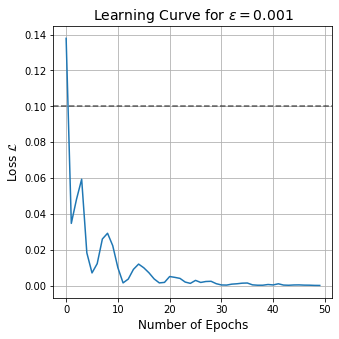

In [11]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(len(losses)), losses)
plt.title('Learning Curve for $\\varepsilon = 0.001$', fontsize=14)
plt.xlabel('Number of Epochs', fontsize=12)
plt.ylabel('Loss $\\mathcal{L}$', fontsize=12)
plt.axhline(y=0.1,color='black',alpha=0.6,linestyle ="--")
plt.grid()
#plt.savefig("figures/loss.png",dpi=dpi)
plt.show()

# Analyzing the trained network

## Accuracy

In [ ]:
def accuracy(outputs, targets):
    
    #final 
    final_outputs = outputs[:,-1,:]
    final_targets = targets[:,-1,:] 
    
    #determine if the sign matches
    correct_predictions = (torch.sign(final_outputs)==torch.sign(final_targets)).float()
    
    #calculate accuracy 
    accuracy = correct_predictions.mean().item()
    
    return accuracy

In [ ]:


x_train,z_train=my_net.forward(train_trial_data[0])
x_test,z_test=my_net.forward(test_trial_data[0])

In [ ]:
# see accuracy on training and testing set
print(f'Training Accuracy: {accuracy(z_train,train_trial_data[1])}')
print(f'Training Accuracy: {accuracy(z_test,test_trial_data[1])}')

Training Accuracy: 1.0
Training Accuracy: 1.0


## Readout trajectories

Plot the mean response of the network along the individual readout trajectories. Use different colors for positive or negaive targets (same for the mean response: compute the mean for positive and negative targets and plot them with 2 different colors.)

In [ ]:
#readout trajectories for the training set

#convert to numpy 
train_out = z_train.detach().numpy()
train_targ = train_trial_data[1].detach().numpy()

#seperate trajectories 
pos_mask = np.where(train_targ[:,-1,:]>0)[0]
neg_mask = np.where(train_targ[:,-1,:]<0)[0]

Text(0, 0.5, 'Readout Value')

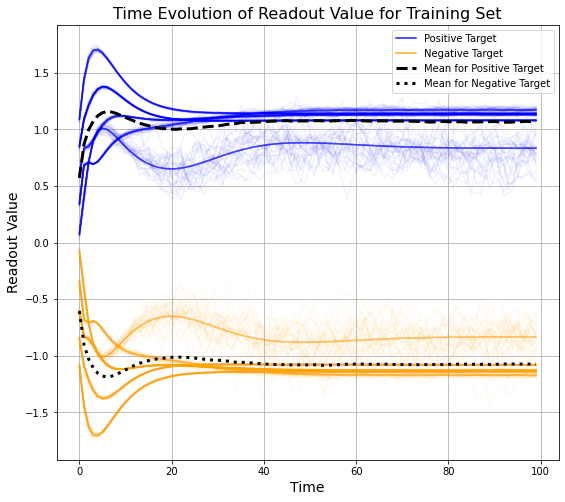

In [16]:
#set up figure 
plt.figure(figsize=(9,8))

# plot trajectories
for i in pos_mask:
    if i == pos_mask[0]: 
        plt.plot(train_out[i, :, 0], color='blue', alpha=0.9,label="Positive Target")
    else: 
        plt.plot(train_out[i, :, 0], color='blue', alpha=0.05) 
        
for j in neg_mask:
    if j==neg_mask[0]: 
        plt.plot(train_out[j,:,0], color = 'orange', alpha=0.9, label="Negative Target") 
    else:
        plt.plot(train_out[j,:,0], color = 'orange', alpha=0.05) 

#mean trajectories
mean_pos = train_out[pos_mask,:,0].mean(axis=0)
mean_neg = train_out[neg_mask,:,0].mean(axis=0)

#plot means 
plt.plot(mean_pos, color ='black', linestyle = '--', linewidth=3, label = 'Mean for Positive Target') 
plt.plot(mean_neg, color ='black', linestyle = ':', linewidth=3, label = 'Mean for Negative Target') 


plt.legend(); plt.grid()
plt.title("Time Evolution of Readout Value for Training Set",fontsize=16)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Readout Value',fontsize=14)
#plt.savefig("figures/readout_train__.png", dpi=dpi)

In [ ]:
#readout trajectories for the training set

#convert to numpy 
train_out = z_test.detach().numpy()
train_targ = test_trial_data[1].detach().numpy()

#seperate trajectories 
pos_mask = np.where(train_targ[:,-1,:]>0)[0]
neg_mask = np.where(train_targ[:,-1,:]<0)[0]

Text(0, 0.5, 'Readout Value')

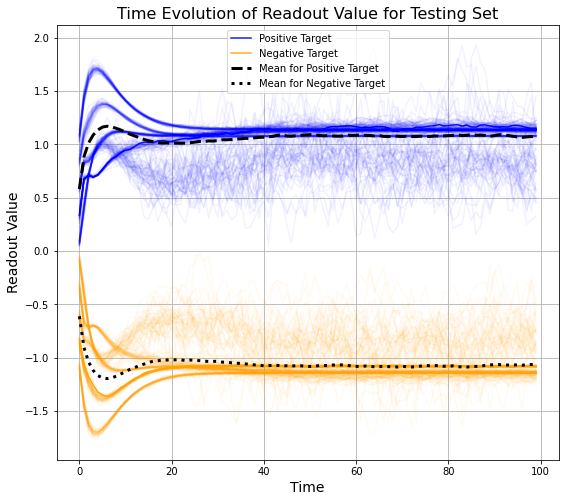

In [18]:
#set up figure 
plt.figure(figsize=(9,8))

# plot trajectories
for i in pos_mask:
    if i == pos_mask[0]: 
        plt.plot(train_out[i, :, 0], color='blue', alpha=0.9,label="Positive Target")
    else: 
        plt.plot(train_out[i, :, 0], color='blue', alpha=0.05) 
        
for j in neg_mask:
    if j==neg_mask[0]: 
        plt.plot(train_out[j,:,0], color = 'orange', alpha=0.9, label="Negative Target") 
    else:
        plt.plot(train_out[j,:,0], color = 'orange', alpha=0.05)

#mean trajectories
mean_pos = train_out[pos_mask,:,0].mean(axis=0)
mean_neg = train_out[neg_mask,:,0].mean(axis=0)

#plot means 
plt.plot(mean_pos, color ='black', linestyle = '--', linewidth=3, label = 'Mean for Positive Target') 
plt.plot(mean_neg, color ='black', linestyle = ':', linewidth=3, label = 'Mean for Negative Target') 


plt.legend(); plt.grid()
plt.title("Time Evolution of Readout Value for Testing Set",fontsize=16)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Readout Value',fontsize=14)
#plt.savefig("figures/readout_test__.png", dpi=dpi)

## Neurons firing rate

The population activity $\phi(\mathbf{x}) = \{\phi(x_i)\}$ does not explore the whole N-dimensional space available to it, but stays confined to a low-dimensional subspace of activity.

To retrieve this subspace, one can apply unsupervised dimensionality reduction techniques like PCA on responses to a set of inputs. First, see the explained variance to detect how many components are needed to explain the data. Then, plot the n eural trajectories in the PCA space, with different colors for different targets.

In [19]:
#we compute the network firing rates for the training and testing set
firing_rates_train=np.tanh(x_train.detach().numpy())               #from voltage x to firing rate phi(x)
firing_rates_test=np.tanh(x_test.detach().numpy())

#flatten data for pca 
firing_rates_train = firing_rates_train.reshape(-1, firing_rates_train.shape[-1])
firing_rates_test = firing_rates_test.reshape(-1, firing_rates_test.shape[-1])

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
#PCA for trainset 

#Step One: Standardize Data 
scaler = StandardScaler() 
firing_rates_train = scaler.fit_transform(firing_rates_train) 

#apply PCA
pca = PCA(n_components=2)
train_reduced = pca.fit_transform(firing_rates_train) 

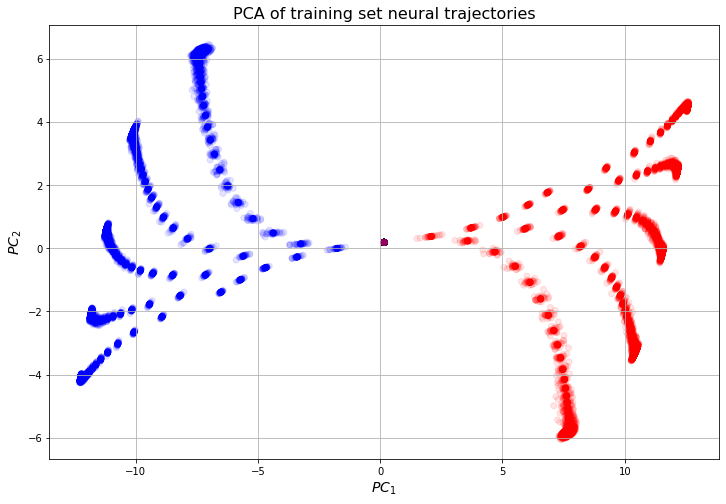

In [22]:
from matplotlib.colors import ListedColormap 

#plot trajectories for train set 
plt.figure(figsize=(12,8)) 

colors = ListedColormap(['blue', 'red'])
lables = np.array([])
for i, _ in enumerate(train_trial_data[1]):
    lables = np.append(lables, np.repeat(train_trial_data[1][i][-1], 101))

plt.scatter(train_reduced[:, 0], train_reduced[:, 1], c=lables, cmap=colors,alpha=0.1)
plt.title('PCA of training set neural trajectories',fontsize=16)
plt.xlabel('$PC_1$',fontsize = 14)
plt.ylabel('$PC_2$',fontsize=14)
plt.grid()
#plt.savefig("figures/trainpca.png",dpi=dpi)
plt.show()

In [23]:
#PCA for Test Set 
firing_rates_train = scaler.fit_transform(firing_rates_test) 

#apply PCA
pca = PCA(n_components=2)
test_reduced = pca.fit_transform(firing_rates_test) 

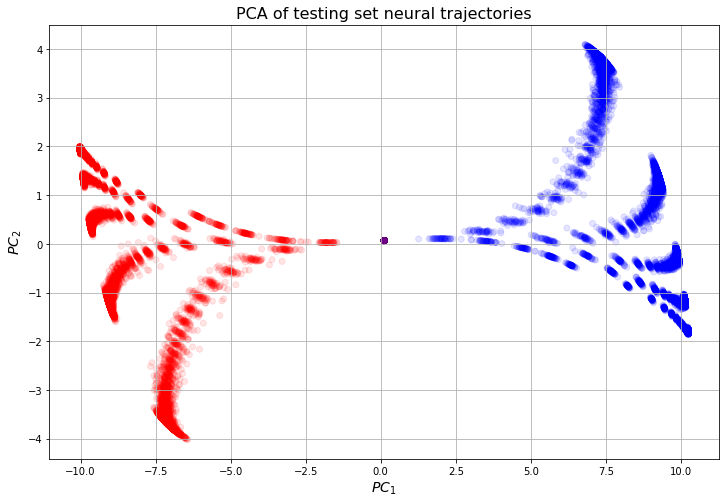

In [24]:
plt.figure(figsize=(12,8)) 

colors = ListedColormap(['blue', 'red'])
lables = np.array([])
for i, _ in enumerate(train_trial_data[1]):
    lables = np.append(lables, np.repeat(test_trial_data[1][i][-1], 101))

plt.scatter(test_reduced[:, 0], test_reduced[:, 1], c=lables, cmap=colors,alpha=0.1)
plt.title('PCA of testing set neural trajectories',fontsize=16)
plt.xlabel('$PC_1$',fontsize=14)
plt.ylabel('$PC_2$',fontsize=14)
plt.grid()
#plt.savefig("figures/testpca.png",dpi=dpi)
plt.show()

## Explained Variance 

In [25]:
# for training set 
#we compute the network firing rates for the training and testing set
firing_rates_train=np.tanh(x_train.detach().numpy())               #from voltage x to firing rate phi(x)
firing_rates_test=np.tanh(x_test.detach().numpy())

#flatten data for pca 
firing_rates_train = firing_rates_train.reshape(-1, firing_rates_train.shape[-1])
firing_rates_test = firing_rates_test.reshape(-1, firing_rates_test.shape[-1])

print(firing_rates_train.shape)

(50500, 128)


[0.8791765  0.97803944 0.9929949  0.99647534 0.99833864]


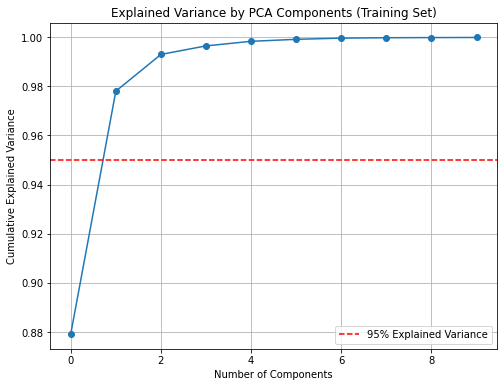

In [26]:
#perform PCA 
plt.figure(figsize=(8, 6))

scaler = StandardScaler() 
firing_rates_train = scaler.fit_transform(firing_rates_train) 
pca = PCA()
train_reduced = pca.fit_transform(firing_rates_train) 

# explained variance 
exp_var = np.cumsum(pca.explained_variance_ratio_)
print(exp_var[:5])

#plot
plt.plot(exp_var[:10], marker='o')


plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components (Training Set)')
plt.legend()
plt.grid()
#plt.savefig("figures/exp_var_train.png",dpi=dpi)
plt.show()

[0.8805562  0.9784653  0.993049   0.9964902  0.99831617]


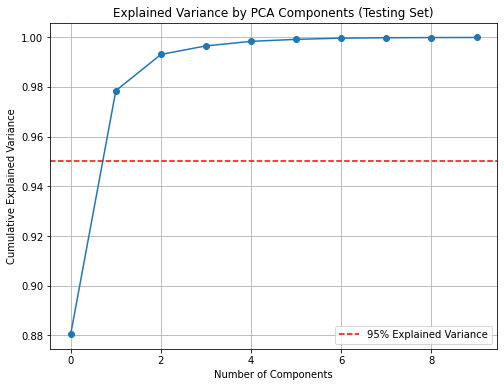

In [27]:
#perform PCA 
scaler = StandardScaler() 
firing_rates_test = scaler.fit_transform(firing_rates_test) 
pca = PCA()
test_reduced = pca.fit_transform(firing_rates_test) 

# explained variance 
exp_var = np.cumsum(pca.explained_variance_ratio_)
print(exp_var[:5])

#plot
plt.figure(figsize=(8, 6))
plt.plot(exp_var[:10], marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components (Testing Set)')
plt.legend()
plt.grid()
#plt.savefig("figures/exp_var_test.png",dpi=dpi)
plt.show()